In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook compute 3 performance metrics (NSE, PBIAS and correlation) for given datasets and a selection of basins. Part 1 selects the basin, the datasets and run through all of them while saving results. Part 2 plots results.

<div class="alert alert-block alert-info">
There is no need to run Part 1, results are already saved. You can jump to part 2 to plot performance tables.
</div>

# 1. Compute performance matrices for selected datasets and basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [2]:
basins=load_basins_data()

In [3]:
selected_basins=basins.copy()
Nbasins=selected_basins.shape[0]

print("There are {} basins in the selection:".format(Nbasins))
for clim in np.unique(selected_basins['CLIMATE']):
    print(str(selected_basins.loc[selected_basins['CLIMATE']==clim].shape[0])+' in climate zone '+str(clim))

There are 194 basins in the selection:
48 in climate zone 4
40 in climate zone 8
18 in climate zone 10
44 in climate zone 13
44 in climate zone 16


We plot selected_basins

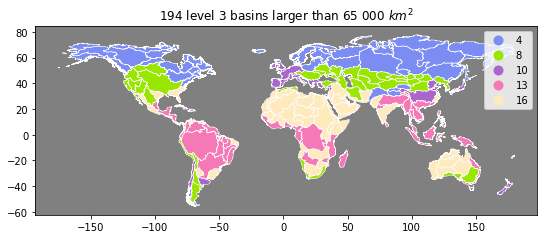

In [5]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_aspect('equal')
basins.plot(ax=ax,edgecolor='white',linewidth=0.5,column='CLIMATE',categorical=True,
            cmap=ListedColormap([climate_colors[i-1] for i in np.unique(basins['CLIMATE'])]),
                  legend=True)
ax.set_facecolor("grey")
ax.set_title('{} level 3 basins larger than 65 000 $km^2$'.format(basins.shape[0]))
plt.show()

List of datasets available for each hydrological variable

In [4]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
              'GLDAS22_CLSM25',
              'MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
             'GLDAS22_CLSM25',
             'GRUN','MERRA2']
#list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']
data_TWS='GRACE_JPL_mascons'

## Computation for all hydrological datasets, over selected basins + performance metrics saved

Is it the first time we run the code with these parameters ?

In [5]:
first_time=True

We initialize the results dataframe

In [6]:
datasets=[]
for d_P in list_data_P:
    for d_ET in list_data_ET:
        for d_R in list_data_R:
            datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))

In [7]:
len(datasets)

1080

In [8]:
if first_time: 
    Ndatasets=0
    df=selected_basins.copy()
    df[datasets]=np.nan*np.ones((selected_basins.shape[0],len(datasets)))
    correlation_tab=df.copy()
    PBIAS_tab=df.copy()
    NSE_tab=df.copy()
    RMSE_tab=df.copy()    
else: # if we want to add new datasets to existing tabs
    Ndatasets=810
    correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    PBIAS_tab=pd.read_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])  
    RMSE_tab=pd.read_csv("../results/water_budget/RMSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])    

In order to compare datasets coherently, the analysis is restricted to the period 2003-2014 where all datasets are available. 

In [9]:
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]

For each dataset, we load the basin timeseries computed by the notebook `Save basins data`, compute the net accumulation and calculate performance metrics. Each performance is saved in the corresponding table.

In [10]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

i=0
for data_P in list_data_P:  
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])
    
    for data_ET in list_data_ET:   
        ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
        time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])
        
        for data_R in list_data_R:   
            R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
            time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 
            
            i+=1
            print("dataset {}/{}".format(i,len(datasets)))

            for basin_name in selected_basins.index:
                P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
                ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
                R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
                TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

                fillingP=(np.sum(np.isnan(P_filter))==0)
                fillingET=(np.sum(np.isnan(ET_filter))==0)
                fillingR=(np.sum(np.isnan(R_filter))==0)
                fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

                if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
                    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
                    TWSC_filter.index=time_idx
                    
                    # compute performance metrics
                    col='P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS)
                    
                    corr=A_filter.corr(TWSC_filter)
                    correlation_tab.loc[basin_name,col]=corr

                    PBIAS=percentage_bias(A_filter,TWSC_filter)
                    PBIAS_tab.loc[basin_name,col]=PBIAS

                    NSE=compute_NSE(A_filter,TWSC_filter)
                    NSE_tab.loc[basin_name,col]=NSE
                    
                    RMSE=compute_RMSE(A_filter,TWSC_filter)
                    RMSE_tab.loc[basin_name,col]=RMSE

# sort datasets by alphabetic order before saving
datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]=='P_')]
no_datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]!='P_')]
correlation_tab2=correlation_tab[no_datasets].join(correlation_tab[datasets.sort_values()])
PBIAS_tab2=PBIAS_tab[no_datasets].join(PBIAS_tab[datasets.sort_values()])
NSE_tab2=NSE_tab[no_datasets].join(NSE_tab[datasets.sort_values()])
RMSE_tab2=RMSE_tab[no_datasets].join(RMSE_tab[datasets.sort_values()])
                
correlation_tab2.to_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
PBIAS_tab2.to_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
NSE_tab2.to_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
RMSE_tab2.to_csv("../results/water_budget/RMSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
first_time=False

dataset 1/1080
dataset 2/1080
dataset 3/1080
dataset 4/1080
dataset 5/1080
dataset 6/1080
dataset 7/1080
dataset 8/1080
dataset 9/1080
dataset 10/1080
dataset 11/1080
dataset 12/1080
dataset 13/1080
dataset 14/1080
dataset 15/1080
dataset 16/1080
dataset 17/1080
dataset 18/1080
dataset 19/1080
dataset 20/1080
dataset 21/1080
dataset 22/1080
dataset 23/1080
dataset 24/1080
dataset 25/1080
dataset 26/1080
dataset 27/1080
dataset 28/1080
dataset 29/1080
dataset 30/1080
dataset 31/1080
dataset 32/1080
dataset 33/1080
dataset 34/1080
dataset 35/1080
dataset 36/1080
dataset 37/1080
dataset 38/1080
dataset 39/1080
dataset 40/1080
dataset 41/1080
dataset 42/1080
dataset 43/1080
dataset 44/1080
dataset 45/1080
dataset 46/1080
dataset 47/1080
dataset 48/1080
dataset 49/1080
dataset 50/1080
dataset 51/1080
dataset 52/1080
dataset 53/1080
dataset 54/1080
dataset 55/1080
dataset 56/1080
dataset 57/1080
dataset 58/1080
dataset 59/1080
dataset 60/1080
dataset 61/1080
dataset 62/1080
dataset 63/1080
d

dataset 490/1080
dataset 491/1080
dataset 492/1080
dataset 493/1080
dataset 494/1080
dataset 495/1080
dataset 496/1080
dataset 497/1080
dataset 498/1080
dataset 499/1080
dataset 500/1080
dataset 501/1080
dataset 502/1080
dataset 503/1080
dataset 504/1080
dataset 505/1080
dataset 506/1080
dataset 507/1080
dataset 508/1080
dataset 509/1080
dataset 510/1080
dataset 511/1080
dataset 512/1080
dataset 513/1080
dataset 514/1080
dataset 515/1080
dataset 516/1080
dataset 517/1080
dataset 518/1080
dataset 519/1080
dataset 520/1080
dataset 521/1080
dataset 522/1080
dataset 523/1080
dataset 524/1080
dataset 525/1080
dataset 526/1080
dataset 527/1080
dataset 528/1080
dataset 529/1080
dataset 530/1080
dataset 531/1080
dataset 532/1080
dataset 533/1080
dataset 534/1080
dataset 535/1080
dataset 536/1080
dataset 537/1080
dataset 538/1080
dataset 539/1080
dataset 540/1080
dataset 541/1080
dataset 542/1080
dataset 543/1080
dataset 544/1080
dataset 545/1080
dataset 546/1080
dataset 547/1080
dataset 548/10

dataset 972/1080
dataset 973/1080
dataset 974/1080
dataset 975/1080
dataset 976/1080
dataset 977/1080
dataset 978/1080
dataset 979/1080
dataset 980/1080
dataset 981/1080
dataset 982/1080
dataset 983/1080
dataset 984/1080
dataset 985/1080
dataset 986/1080
dataset 987/1080
dataset 988/1080
dataset 989/1080
dataset 990/1080
dataset 991/1080
dataset 992/1080
dataset 993/1080
dataset 994/1080
dataset 995/1080
dataset 996/1080
dataset 997/1080
dataset 998/1080
dataset 999/1080
dataset 1000/1080
dataset 1001/1080
dataset 1002/1080
dataset 1003/1080
dataset 1004/1080
dataset 1005/1080
dataset 1006/1080
dataset 1007/1080
dataset 1008/1080
dataset 1009/1080
dataset 1010/1080
dataset 1011/1080
dataset 1012/1080
dataset 1013/1080
dataset 1014/1080
dataset 1015/1080
dataset 1016/1080
dataset 1017/1080
dataset 1018/1080
dataset 1019/1080
dataset 1020/1080
dataset 1021/1080
dataset 1022/1080
dataset 1023/1080
dataset 1024/1080
dataset 1025/1080
dataset 1026/1080
dataset 1027/1080
dataset 1028/1080
da

In [12]:
basin_name

1030000010

# 2. Results

## 2.1. Functions to plot nice tables

Function to draw column separation between datasets.

In [2]:
def find_separation_datasets(datasets):
    # name of datasets
    data_P=[]
    data_ET=[]
    data_R=[]
    for data_name in datasets:
        iP=data_name.find('_ET')
        data_P.append(data_name[:iP])
        iET=data_name.find('_R',iP+1)
        data_ET.append(data_name[iP+1:iET])
        iR=data_name.find('_TWS',iET+1)
        data_R.append(data_name[iET+1:iR])
    
    sep_P=np.unique(data_P,return_index=True)[1]
    sep_P_unsorted=sep_P.copy()
    sep_P.sort()
    sep_ET=[]
    for i in range(len(sep_P)-1):
        sep_ET+=list(sep_P[i]+np.unique(data_ET[sep_P[i]:sep_P[i+1]],return_index=True)[1])
    sep_ET+=list(sep_P[-1]+np.unique(data_ET[sep_P[-1]:],return_index=True)[1])

    return data_P,data_ET,data_R,sep_P_unsorted,sep_ET

Grey hatched boxes are shown in the performance tabs in each basin where at least 1 dataset is lacking. 

## 2.2. NSE over all basins and some datasets combinations

In [3]:
%matplotlib notebook

basins=load_basins_data()
Nbasins=basins.shape[0]
Ndatasets=1080
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

Extract the list of datasets combinations from the columns names and find the list of datasets used for each hydrological variable.

In [4]:
datasets=NSE_tab.columns
data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)

Restrict the datasets to promising datasets.

In [5]:
promising_datasets=[]
for d_P in ['ERA5_Land','GPCP','GPM']:
    for d_ET in ['GLEAM','GLDAS21_CLSM25','GLDAS20_CLSM25']:
        for d_R in ['ERA5_Land','GRUN','MERRA2']:
            promising_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
len(promising_datasets)

27

## 2.3. Statistics to rank datasets combinations

Combinations are ranked per decreasing number of basins performing at least good (NSE>=0.5)

In [45]:
full_datasets=[]
for d_P in ['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP']:
    for d_ET in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GLEAM','MERRA2','SSEBop']:
        for d_R in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GRUN','MERRA2']:
            full_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[full_datasets]),axis=1)==0)]
full_basins.shape

(133,)

Use all datasets but with only non missing basins

In [10]:
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[datasets]),axis=1)==0)]
full_datasets=datasets
full_basins.shape

(70,)

To include all datasets in the ranking

In [5]:
full_basins=NSE_tab.index
full_datasets=datasets
full_basins.shape

(194,)

<IPython.core.display.Javascript object>


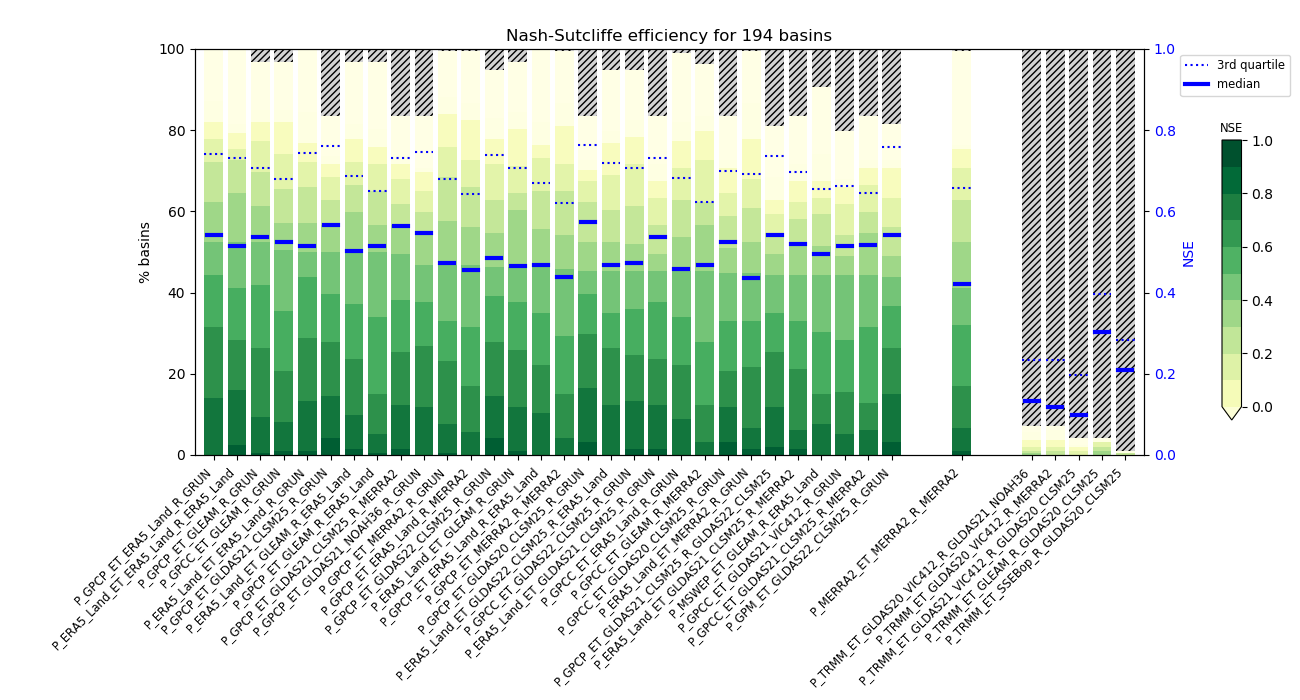

In [6]:
limitsNSE=list(np.arange(0.9,-0.1,-0.1))
my_cmap = plt.cm.get_cmap('YlGn')

# compute the number of basins in each NSE category for all datasets
select_NSE_tab=NSE_tab.loc[full_basins,full_datasets]
nb_very_good=np.sum(select_NSE_tab>=0.75,axis=0)
nb_good=np.sum(select_NSE_tab>=0.5,axis=0)

datasets_perf=nb_very_good.to_frame(name='very good')
datasets_perf['good']=nb_good

# sort datasets combinations per decreasing number of basins at least good
plot_good=30
plot_bad=5
sorted_datasets=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[:plot_good])
xdatasets=list(np.arange(plot_good))
for my_combination in ['P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS),'P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)]:
    if not(my_combination in sorted_datasets):
        sorted_datasets.append(my_combination)
        xdatasets.append(xdatasets[-1]+3)

sorted_datasets+=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[-plot_bad:])
xdatasets+=list(np.arange(xdatasets[-1]+3,xdatasets[-1]+3+plot_bad))

select_NSE_tab=select_NSE_tab[sorted_datasets]
nb_basins=select_NSE_tab.shape[0]
nb_datasets=select_NSE_tab.shape[1]

width=0.8

fig, ax1 = plt.subplots(figsize=(13,7))

bottom=np.zeros(nb_datasets)
for lim in limitsNSE:
    basinsNSE=100*np.sum(select_NSE_tab>=lim,axis=0)/nb_basins-bottom
    ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(lim+0.01))
    bottom+=basinsNSE

# poorest performance
basinsNSE=100*np.sum(select_NSE_tab<lim,axis=0)/nb_basins
ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(0))
bottom=bottom+basinsNSE

ax1.bar(xdatasets,100-bottom,width,
        bottom=bottom,color='lightgrey',hatch='/////')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot medians
for i,med in zip(xdatasets,select_NSE_tab.median(axis=0)):
    line1,=ax2.plot([i-(width-0.2)/2,i+(width-0.2)/2],[med,med],'b',linewidth=3)
    
for i,med in zip(xdatasets,select_NSE_tab.quantile(0.75,axis=0)):
    line2,=ax2.plot([i-(width)/2,i+(width)/2],[med,med],'b:')

ax2.legend([line2,line1],['3rd quartile','median'],loc='upper right', bbox_to_anchor=(1.16, 1.),fontsize='small')
ax2.set_ylim([0,1])
ax2.set_ylabel('NSE',color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(xdatasets)
ax1.set_xticklabels(select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=45,ha='right',fontsize='small')
#plt.xticks(xdatasets,select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=90,fontsize='small')
ax1.set_xlim([-width,xdatasets[-1]+width])
ax1.set_ylim([0,100])

plt.title('Nash-Sutcliffe efficiency for {} basins'.format(nb_basins))
ax1.set_ylabel('% basins')  


fig.subplots_adjust(left=0.15,bottom=0.35, right=0.88, top=0.93)
cax = plt.axes([0.94, 0.4, 0.015, 0.4])
    
clb=fig.colorbar(
        ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(-0.1,1)),
        cax=cax,
        fraction=0.01,
        boundaries=[-0.1] + limitsNSE[::-1] + [1],  # Adding values for extensions.
        extend='min',
        ticks=[-0.1]+limitsNSE[::-1][::2]+[1],
        spacing='proportional',
    )
clb.ax.set_title('NSE',fontsize='small') 
#plt.tight_layout()
plt.show()

## Tables of performances per hydrological variable

In [8]:
def findnth(haystack, needle, n):
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

In [9]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    #return ['background-color: yellow' if v else '' for v in is_max]
    return ['font-weight: bold' if v else '' for v in is_max]

Tables of NSE distribution and percentage of basins in each performance category for all datasets

In [39]:
hydro_var_name='R'
method='all' # 'best' to compute percentage over the best combination, 'all' to compute over all combinations
#climate='all'
climate=[16] # 'all' to include all basins or a list between 1 and 18 to restrict to a given climate zone


if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]

stats=pd.DataFrame(np.zeros((list_data.shape[0],7)),index=list_data,
                   columns=['median','1st quartile','3rd quartile','% very good','% good','% acceptable','% poor'])

for data in list_data:
    select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
    
    if climate=='all':
        select_NSE_tab=NSE_tab[select_datasets]
    else:
        select_NSE_tab=NSE_tab.loc[basins['CLIMATE'].isin(climate),select_datasets]
    #print('You selected {} basins'.format(select_NSE_tab.shape[0]))
    temp=select_NSE_tab.values.flatten()
    (nb_basins,nb_datasets)=select_NSE_tab.shape
    
    # do we want percentages over all basins or non-missing values ?
    #nb_nan=np.sum(np.isnan(temp))
    nb_nan=0
    
    temp=temp[~np.isnan(temp)]
    stats.loc[data,'median']=np.median(temp)
    stats.loc[data,'1st quartile']=np.percentile(temp, 25, interpolation = 'midpoint') 
    stats.loc[data,'3rd quartile']=np.percentile(temp, 75, interpolation = 'midpoint') 
    if method=='best':
        stats.loc[data,'% very good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.75)/(nb_basins)
        stats.loc[data,'% good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.5)/(nb_basins)
        stats.loc[data,'% acceptable']=100*np.sum(select_NSE_tab.max(axis=1)>=0.2)/(nb_basins)
        stats.loc[data,'% poor']=100*np.sum(select_NSE_tab.max(axis=1)<0.2)/(nb_basins)
    elif method=='all':
        stats.loc[data,'% very good']=100*np.sum(temp>=0.75)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% good']=100*np.sum(temp>=0.5)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% acceptable']=100*np.sum(temp>=0.2)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% poor']=100*np.sum(temp<0.2)/(nb_basins*nb_datasets-nb_nan)

stats.style.apply(highlight_max).format("{:.2f}")

,median,1st quartile,3rd quartile,% very good,% good,% acceptable,% poor
ERA5_Land,0.21,-0.13,0.55,6.27,22.29,37.96,37.31
GLDAS20_CLSM25,0.14,-0.31,0.47,2.90,10.16,19.68,25.19
GLDAS20_NOAH36,0.17,-0.15,0.47,2.46,16.48,34.39,38.83
GLDAS20_VIC412,0.05,-0.24,0.28,0.36,6.63,22.92,48.95
GLDAS21_CLSM25,0.15,-0.25,0.48,2.90,12.04,23.15,27.67
GLDAS21_NOAH36,0.15,-0.18,0.46,2.36,16.12,33.67,39.54
GLDAS21_VIC412,0.02,-0.30,0.24,0.40,6.38,20.52,51.35
GLDAS22_CLSM25,0.17,-0.19,0.52,5.20,19.84,35.82,39.08
GRUN,0.24,-0.10,0.60,8.71,24.56,39.67,35.61
MERRA2,0.20,-0.14,0.52,5.79,20.60,37.79,37.48


Format latex tab with optimal values in bold

In [34]:
str_latex=stats.to_latex(float_format="%.2f")
columns_descr='{} & \\thead{median} & \\thead{1st quartile} &  \\thead{3rd quartile} &'
columns_descr+='\\thead{ \\% very good \\\\ (NSE $ \\ge 0.75 $) } &'
columns_descr+='\\thead{ \\% good \\\\ (NSE $ \\ge 0.5 $) } &'
columns_descr+='\\thead{ \\% acceptable \\\\ (NSE $ \\ge 0.2 $) } &'
columns_descr+='\\thead{ \\% poor \\\\ (NSE $ < 0.2 $) }  \\\\\n'
str_latex=str_latex[:str_latex.find('\\toprule')+9]+columns_descr+str_latex[str_latex.find('\\midrule'):]

for i,col in enumerate(stats.columns[:-1]):
    best_dataset=stats.index[stats[col].argmax()]
    
    ind=str_latex.find(best_dataset.replace('_','\_'))
    first_sep=findnth(str_latex[ind:],'&',i)+ind
    second_sep=findnth(str_latex[ind:],'&',i+1)+ind
    
    #print(best_dataset,first_sep,second_sep)
    
    #first_sep=str_latex.find('&',ind)
    #second_sep=str_latex.find('&',first_sep+1)
    
    str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# add the minimum for the last column
col=stats.columns[-1]
best_dataset=stats.index[stats[col].argmin()]
    
ind=str_latex.find(best_dataset.replace('_','\_'))
first_sep=findnth(str_latex[ind:],'&',i+1)+ind
second_sep=str_latex.find('\\',first_sep+1)
str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# format datasets names
str_latex=str_latex.replace('\_',' ')
str_latex=str_latex.replace('GLDAS20','GLDAS2.0')
str_latex=str_latex.replace('GLDAS21','GLDAS2.1')
str_latex=str_latex.replace('GLDAS22','GLDAS2.2')

str_latex=str_latex.replace('CLSM25','CLSM2.5')
str_latex=str_latex.replace('NOAH36','NOAH3.6')
str_latex=str_latex.replace('VIC412','VIC4.1.2')

str_latex='\\resizebox{ \\textwidth}{!}{' + str_latex[:-1] + '}'

print(str_latex)

\resizebox{ \textwidth}{!}{\begin{tabular}{lrrrrrrr}
\toprule
{} & \thead{median} & \thead{1st quartile} &  \thead{3rd quartile} &\thead{ \% very good \\ (NSE $ \ge 0.75 $) } &\thead{ \% good \\ (NSE $ \ge 0.5 $) } &\thead{ \% acceptable \\ (NSE $ \ge 0.2 $) } &\thead{ \% poor \\ (NSE $ < 0.2 $) }  \\
\midrule
ERA5 Land      &\textbf {0.47}&          0.23 &\textbf {0.65}&\textbf {9.97}&\textbf {37.18}&         62.09 &   17.63 \\
GLDAS2.0 CLSM2.5 &    0.28 &         -0.08 &          0.52 &         5.34 &   20.53 &         43.97 &   32.57 \\
GLDAS2.0 NOAH3.6 &    0.31 &         -0.01 &          0.55 &         5.94 &   22.69 &         46.33 &   30.21 \\
GLDAS2.0 VIC4.1.2 &    0.44 &          0.25 &          0.61 &         5.68 &   30.52 &         61.37 &   15.18 \\
GLDAS2.1 CLSM2.5 &    0.27 &         -0.03 &          0.52 &         4.67 &   20.41 &         43.41 &   33.13 \\
GLDAS2.1 NOAH3.6 &    0.38 &          0.18 &          0.56 &         4.18 &   24.85 &         55.76 &   20.79 \\
G

### Winner dataset

In [40]:
hydro_var_name='R'
data='GRUN'

winner=pd.DataFrame(np.nan*np.ones((NSE_tab.shape[0],2)),index=NSE_tab.index,columns=[data,'ref {}'.format(data)])

if hydro_var_name=='P':
    list_data=pd.Index(np.unique(data_P)).str[len(hydro_var_name)+1:]
if hydro_var_name=='ET':
    list_data=pd.Index(np.unique(data_ET)).str[len(hydro_var_name)+1:]
if hydro_var_name=='R':
    list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]
    
select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
ref_datasets=list(set(datasets)-set(select_datasets))
select_NSE_tab=NSE_tab[select_datasets] # we select all columns containing 'data'
ref_NSE_tab=NSE_tab[ref_datasets] # all columns not containing 'data'

winner[data]=select_NSE_tab.median(axis=1)
winner['ref {}'.format(data)]=ref_NSE_tab.median(axis=1)

winner['{} - ref'.format(data)]=winner[data]-winner['ref {}'.format(data)]

In [41]:
basins=load_basins_data()

<IPython.core.display.Javascript object>


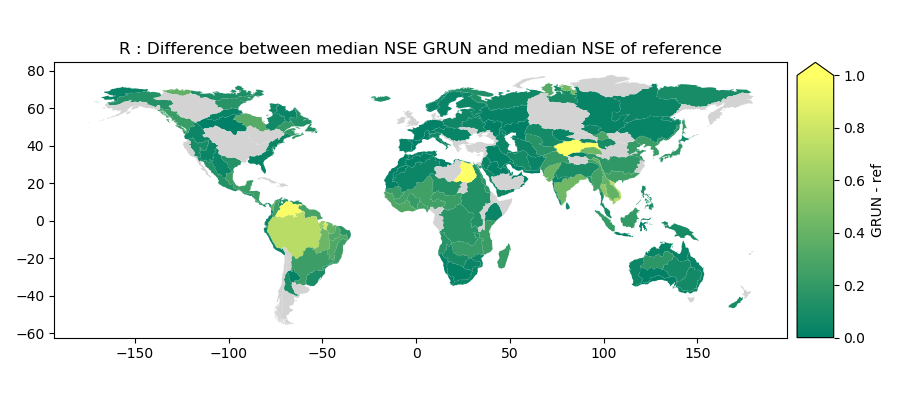

In [42]:
from matplotlib.cm import ScalarMappable

basins['{} - ref'.format(data)]=np.where(winner['{} - ref'.format(data)]<0,np.nan,winner['{} - ref'.format(data)])

my_cmap = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
basins.plot(ax=ax,column='{} - ref'.format(data),
                          legend=True,cax=cax,
                         vmin=0,
                     vmax=min(1.0,basins['{} - ref'.format(data)].max()),
                     #vmax=np.percentile(basins['{} - ref'.format(data)],98),
                          missing_kwds={"color": "lightgrey"},
                          legend_kwds={'label': "{} - ref".format(data),
                              'extend':'max'
                                      },
                         cmap='summer'
                    )

ax.set_title('{} : Difference between median NSE {} and median NSE of reference'.format(hydro_var_name,data)) 
plt.tight_layout()
plt.show()

In [49]:
basins.sort_values(by='{} - ref'.format(data),ascending=False)

,AREA,CLIMATE,geometry,GPCC - ref
HYBAS_ID,,,,
1030040280,2.572690e+05,16,"POLYGON ((24.22500 18.63750, 24.21744 18.63673...",0.406693
1030040310,2.436015e+06,17,"POLYGON ((-10.70417 23.62500, -10.71160 23.625...",0.375673
1030040210,1.342537e+06,17,"POLYGON ((9.10417 18.34167, 9.10328 18.34512, ...",0.346613
4030017020,7.732306e+05,18,"POLYGON ((105.23333 10.32083, 105.21424 10.321...",0.320514
4030033640,8.640621e+05,6,"POLYGON ((68.65833 33.72917, 68.65174 33.72881...",0.280017
...,...,...,...,...
7030034520,1.055756e+06,7,"POLYGON ((-89.97917 46.27083, -89.97973 46.281...",NaN
7030034530,1.986787e+05,7,"MULTIPOLYGON (((-63.91667 46.67917, -63.91610 ...",NaN
7030073620,5.215250e+05,8,"POLYGON ((-114.93750 37.72917, -114.93785 37.7...",NaN
